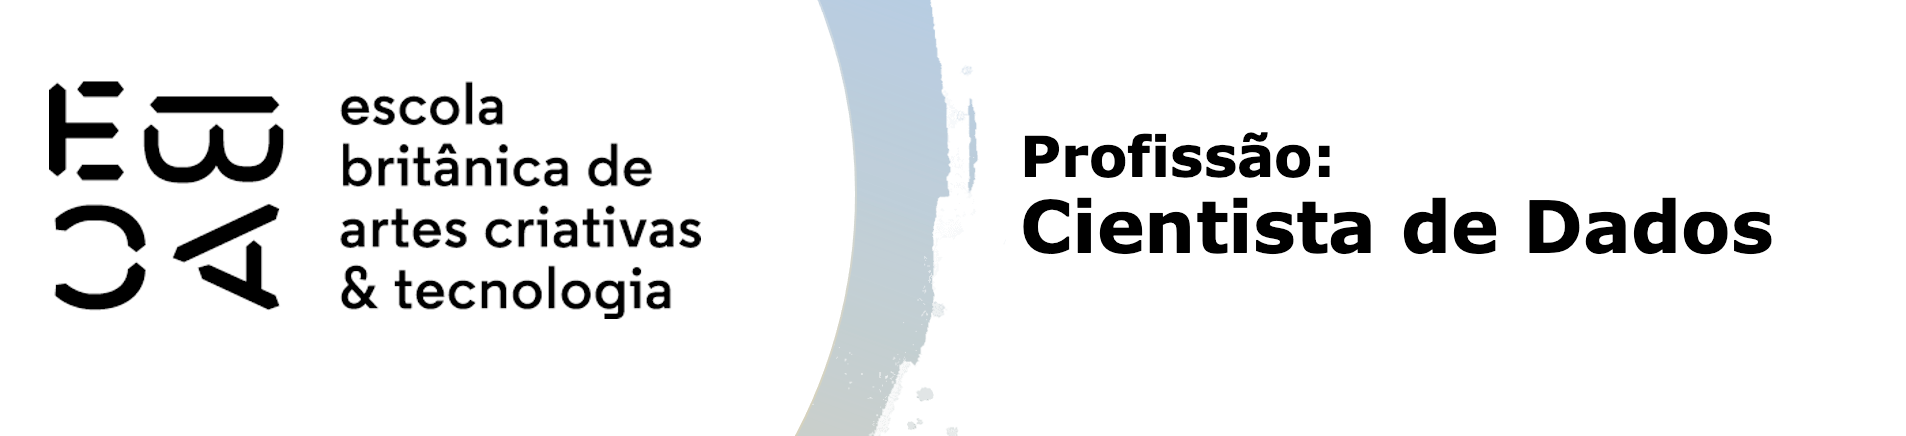

# Tarefa II

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

df = pd.read_pickle('base_nfp.pkl')
df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,0.016233,1,Restaurantes
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,0.016240,1,Restaurantes


In [49]:
print(df.columns)

Index(['CNPJ emit.', 'Emitente', 'No.', 'Data Emissão', 'Valor NF',
       'Data Registro', 'Créditos', 'Situação do Crédito', 'Ano', 'Semestre',
       'Retorno', 'flag_credito', 'categoria'],
      dtype='object')


## Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

In [50]:
# Criar variáveis temporais
df['Data Emissão'] = pd.to_datetime(df['Data Emissão'])
df['Dia da Semana'] = df['Data Emissão'].dt.dayofweek  # 0 (segunda-feira) a 6 (domingo)
df['Fim de Semana'] = df['Dia da Semana'].isin([5, 6]).astype(int)  # 1 se for fim de semana, 0 caso contrário
df['Dia do Mês'] = df['Data Emissão'].dt.day
df['Mês'] = df['Data Emissão'].dt.month
df['Trimestre'] = df['Data Emissão'].dt.quarter

# Criar categorizações da variável Valor NF
quantis = [0, 0.2, 0.4, 0.8, 1.0]  # Quantis para categorização
num_categories = [5, 10, 20, 50]  # Número de categorias desejadas

for num in num_categories:
    for q in quantis:
        col_name = f'Valor NF Cat_{num}q_{int(q*100)}'
        df[col_name] = pd.qcut(df['Valor NF'], num, labels=False, duplicates='drop')

# Visualizar o DataFrame após as transformações
print(df.head())


           CNPJ emit.                                           Emitente  \
0  03.476.811/0741-98                      DIA BRASIL SOCIEDADE LIMITADA   
1  43.101.310/0001-05                         AUTO POSTO ZANWAL LTDA EPP   
2  23.750.257/0001-66  OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE   
3  23.750.257/0001-66  OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE   
4  23.750.257/0001-66  OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE   

    No. Data Emissão  Valor NF Data Registro  Créditos Situação do Crédito  \
0   537   2017-06-30     24.68    2017-06-30      0.00            Liberado   
1  2894   2017-06-30     50.00    2017-06-30      0.00            Liberado   
2   699   2017-06-30     27.00    2017-06-30      0.44            Liberado   
3   698   2017-06-30    111.50    2017-06-30      1.81            Liberado   
4   694   2017-06-30    125.00    2017-06-30      2.03            Liberado   

    Ano  Semestre  ...  Valor NF Cat_20q_0  Valor NF Cat_20q_20  \
0  2017

## Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

In [51]:
%%time

def calculate_iv(df, feature, target):
    freq_table = pd.crosstab(df[feature], df[target], margins=True)
    freq_table['event_rate'] = freq_table[1] / freq_table['All']
    freq_table['non_event_rate'] = freq_table[0] / freq_table['All']
    freq_table['event_diff'] = freq_table['event_rate'] - freq_table['non_event_rate']
    freq_table['IV'] = freq_table['event_diff'] * np.log(freq_table['event_rate'] / freq_table['non_event_rate'])
    iv = freq_table['IV'].sum()
    return iv

# Suprimir os avisos de RuntimeWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Defina a variável de destino
target_variable = 'flag_credito'

# Calcula o IV para cada variável e armazena em um dicionário
iv_results = {}
for variable in df.columns:
    if variable != target_variable:  # Não calcula IV para a variável de destino
        iv = calculate_iv(df, variable, target_variable)
        iv_results[variable] = iv

# Exibe os resultados do IV para cada variável, excluindo os que são "inf"
for variable, iv in iv_results.items():
    if iv != float('inf'):
        print(f"IV da variável '{variable}': {iv}")
        
print()

IV da variável 'Ano': 0.19235253099839125
IV da variável 'Semestre': 0.061035501657298596
IV da variável 'categoria': 4.867850986669221
IV da variável 'Dia da Semana': 0.17600285946525485
IV da variável 'Fim de Semana': 0.050611460383493276
IV da variável 'Dia do Mês': 1.1464823692490231
IV da variável 'Mês': 0.389413346345585
IV da variável 'Trimestre': 0.11711427684086441
IV da variável 'Valor NF Cat_5q_0': 0.257110605653575
IV da variável 'Valor NF Cat_5q_20': 0.257110605653575
IV da variável 'Valor NF Cat_5q_40': 0.257110605653575
IV da variável 'Valor NF Cat_5q_80': 0.257110605653575
IV da variável 'Valor NF Cat_5q_100': 0.257110605653575
IV da variável 'Valor NF Cat_10q_0': 0.7444672802527526
IV da variável 'Valor NF Cat_10q_20': 0.7444672802527526
IV da variável 'Valor NF Cat_10q_40': 0.7444672802527526
IV da variável 'Valor NF Cat_10q_80': 0.7444672802527526
IV da variável 'Valor NF Cat_10q_100': 0.7444672802527526
IV da variável 'Valor NF Cat_20q_0': 1.656254782289584
IV da va

## Conclua

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?

> * <span style="font-family: Serif; color: green;">As variáveis que apresentam maior poder de discriminação segundo o IV são: <b>['Valor NF Cat_50q_0', 'Valor NF Cat_50q_20', 'Valor NF Cat_50q_40', 'Valor NF Cat_50q_80', 'Valor NF Cat_50q_100'] ['Valor NF Cat_20q_0', 'Valor NF Cat_20q_20', 'Valor NF Cat_20q_40', 'Valor NF Cat_20q_80', 'Valor NF Cat_20q_100']</b> e <b>'Dia do Mês'</b>.</span>

> * <span style="font-family: Serif; color: green;"> O Número de categorias parece não estar afetando diretamente o valor do IV para essas variáveis, por exemplo todas as categorias relacionadas a uma mesma variável como "Valor NF Cat_xx_y" tem os mesmos valores, mas não é possível descartar totalmente a possibilidade de haver alguma relação entre o número de categorias e o IV em determinados casos, só não é uma regra geral. </span>


In [52]:
print(df.columns)

Index(['CNPJ emit.', 'Emitente', 'No.', 'Data Emissão', 'Valor NF',
       'Data Registro', 'Créditos', 'Situação do Crédito', 'Ano', 'Semestre',
       'Retorno', 'flag_credito', 'categoria', 'Dia da Semana',
       'Fim de Semana', 'Dia do Mês', 'Mês', 'Trimestre', 'Valor NF Cat_5q_0',
       'Valor NF Cat_5q_20', 'Valor NF Cat_5q_40', 'Valor NF Cat_5q_80',
       'Valor NF Cat_5q_100', 'Valor NF Cat_10q_0', 'Valor NF Cat_10q_20',
       'Valor NF Cat_10q_40', 'Valor NF Cat_10q_80', 'Valor NF Cat_10q_100',
       'Valor NF Cat_20q_0', 'Valor NF Cat_20q_20', 'Valor NF Cat_20q_40',
       'Valor NF Cat_20q_80', 'Valor NF Cat_20q_100', 'Valor NF Cat_50q_0',
       'Valor NF Cat_50q_20', 'Valor NF Cat_50q_40', 'Valor NF Cat_50q_80',
       'Valor NF Cat_50q_100'],
      dtype='object')


## Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

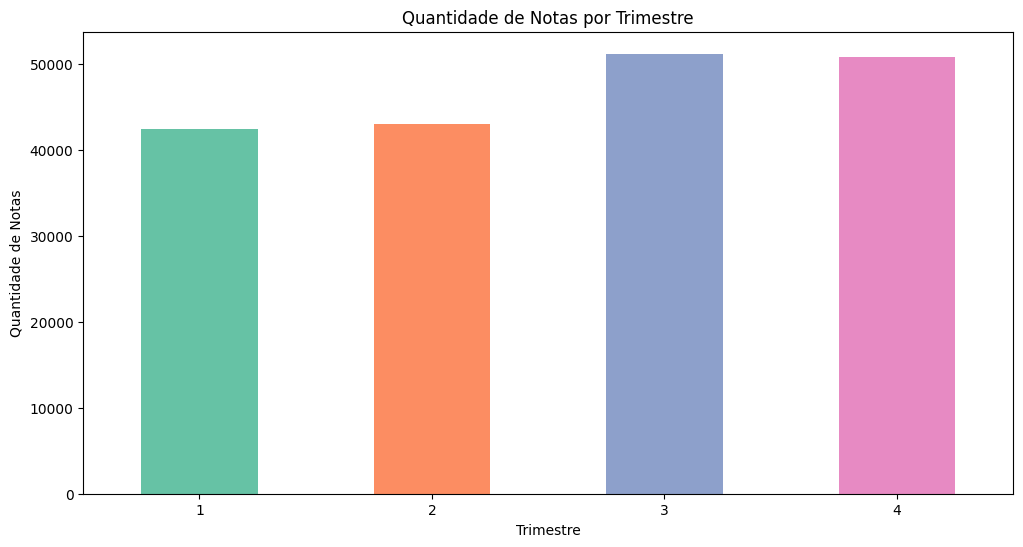

<Figure size 1200x800 with 0 Axes>

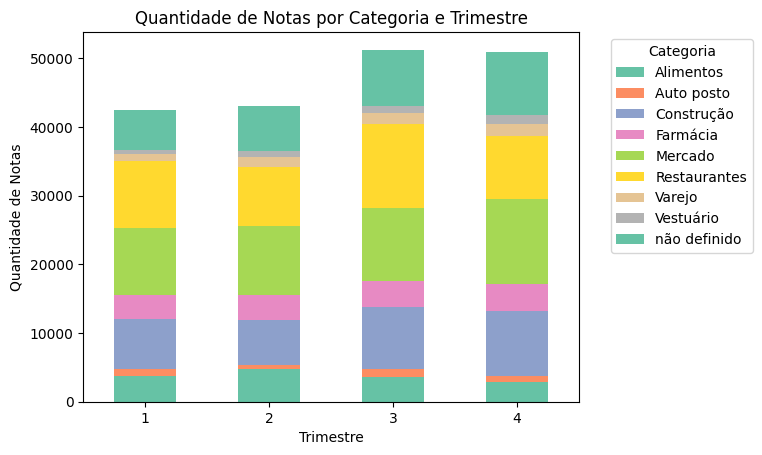

<Figure size 1200x800 with 0 Axes>

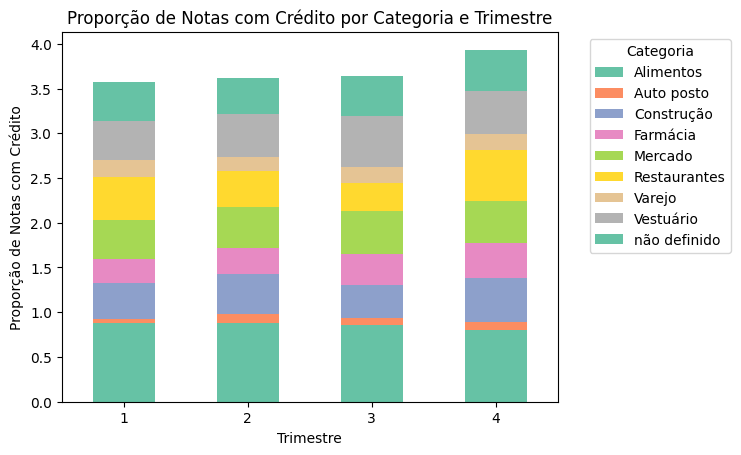

In [53]:
# Análise descritiva básica no tempo
trimestre_counts = df.groupby('Trimestre')['No.'].count()
categoria_trimestre_counts = df.groupby(['Trimestre', 'categoria'])['No.'].count().unstack()
proporcao_credito_categoria_trimestre = df.groupby(['Trimestre', 'categoria'])['flag_credito'].mean().unstack()

# Definir paleta de cores personalizada
cores_personalizadas = sns.color_palette("Set2", n_colors=len(categoria_trimestre_counts.columns))

# Plotar gráfico de quantidade de notas por trimestre
plt.figure(figsize=(12, 6))
trimestre_counts.plot(kind='bar', color=cores_personalizadas)
plt.title('Quantidade de Notas por Trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Quantidade de Notas')
plt.xticks(rotation=0)
plt.show()

# Plotar gráfico de quantidade de notas por categoria e trimestre
plt.figure(figsize=(12, 8))
ax = categoria_trimestre_counts.plot(kind='bar', stacked=True, color=cores_personalizadas)
plt.title('Quantidade de Notas por Categoria e Trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Quantidade de Notas')
plt.xticks(rotation=0)
plt.legend(title='Categoria', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Plotar gráfico de proporção de notas com crédito por categoria e trimestre
plt.figure(figsize=(12, 8))
ax = proporcao_credito_categoria_trimestre.plot(kind='bar', stacked=True, color=cores_personalizadas)
plt.title('Proporção de Notas com Crédito por Categoria e Trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Proporção de Notas com Crédito')
plt.xticks(rotation=0)
plt.legend(title='Categoria', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

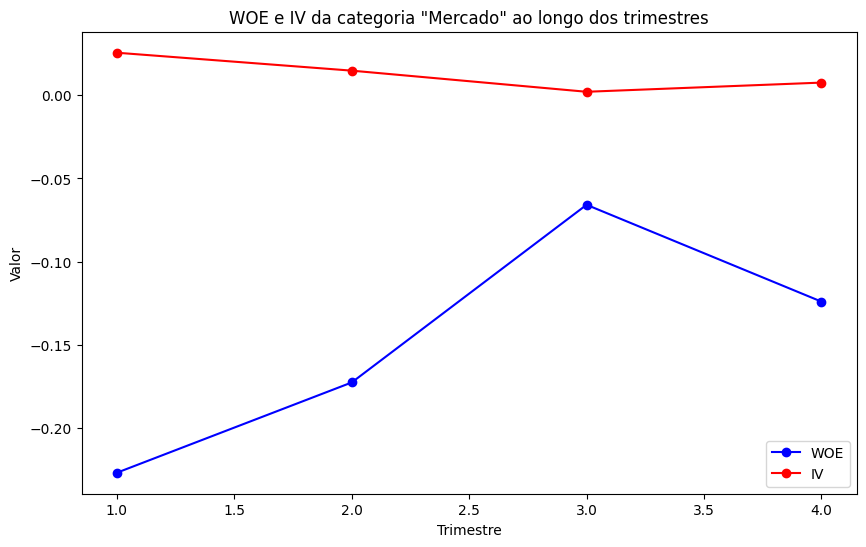

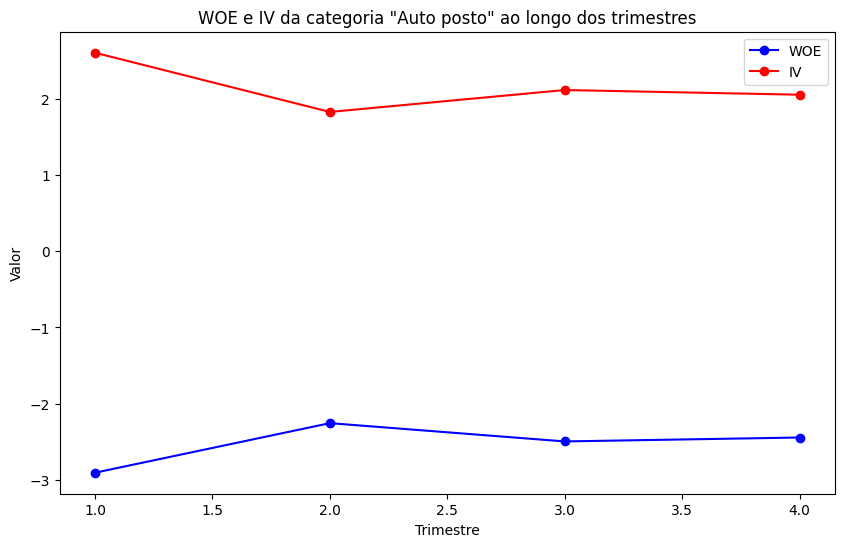

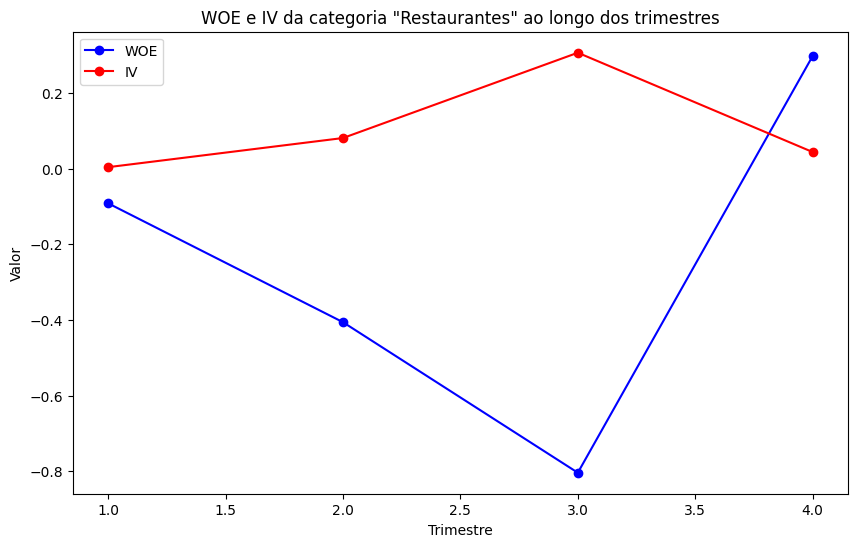

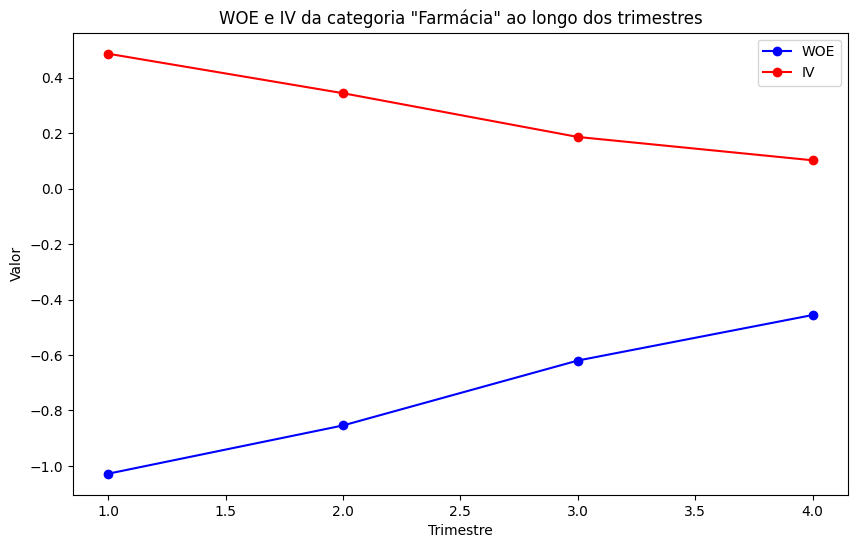

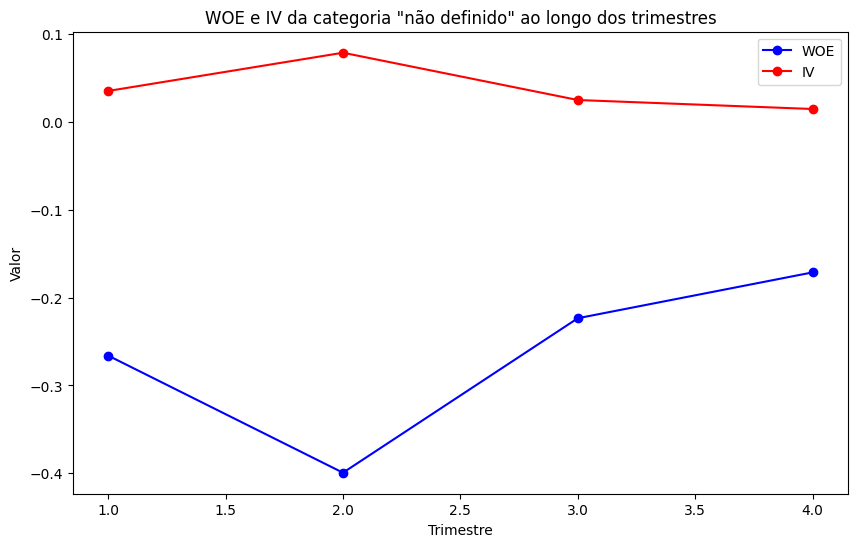

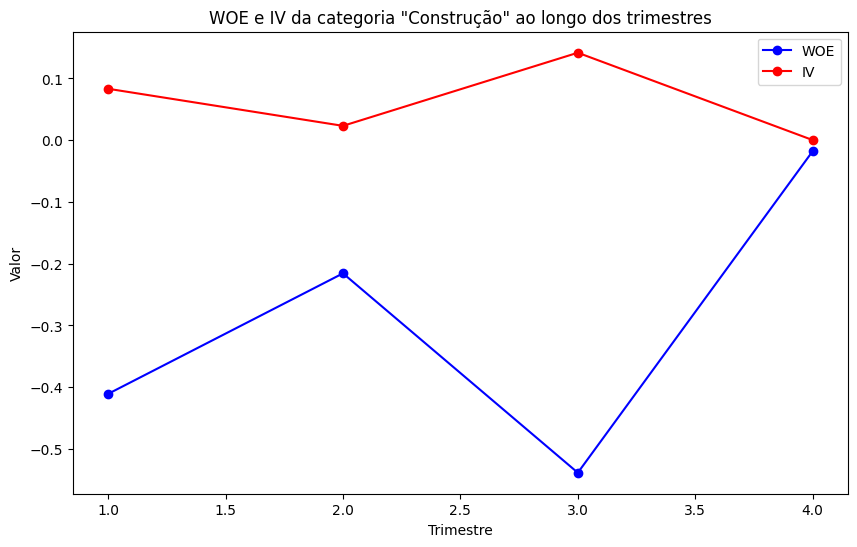

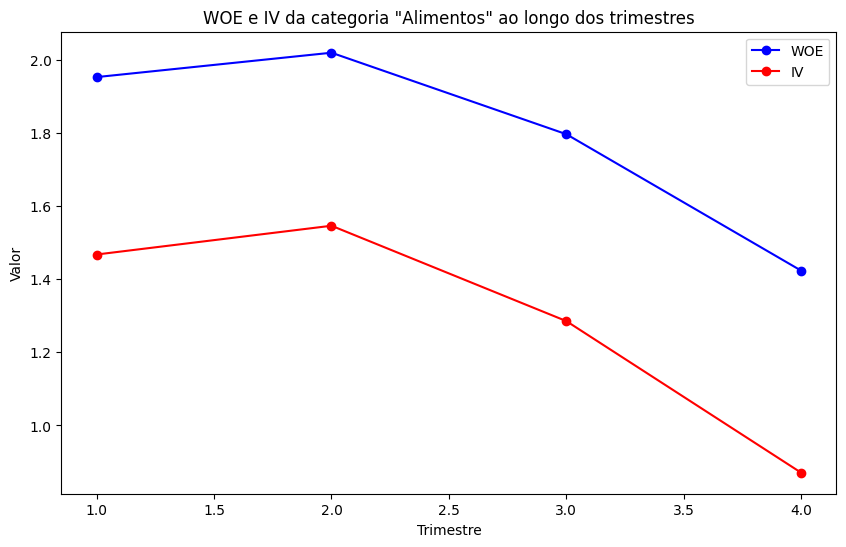

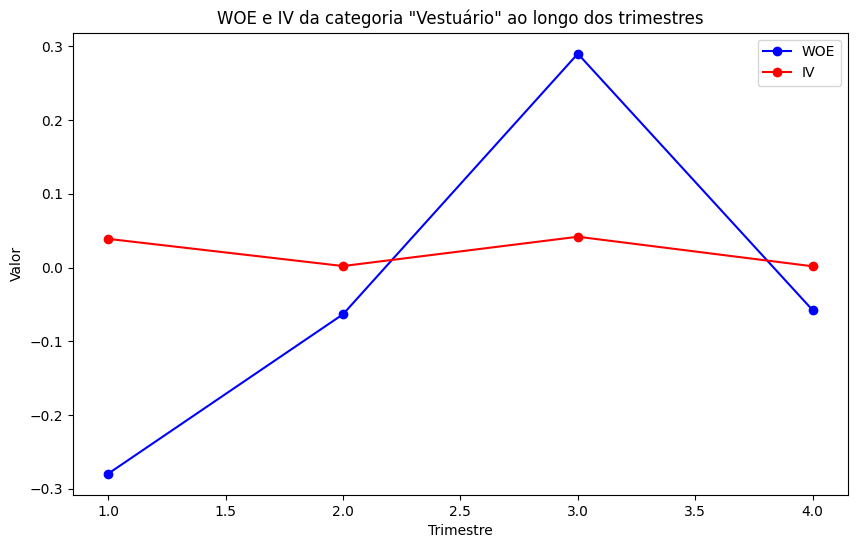

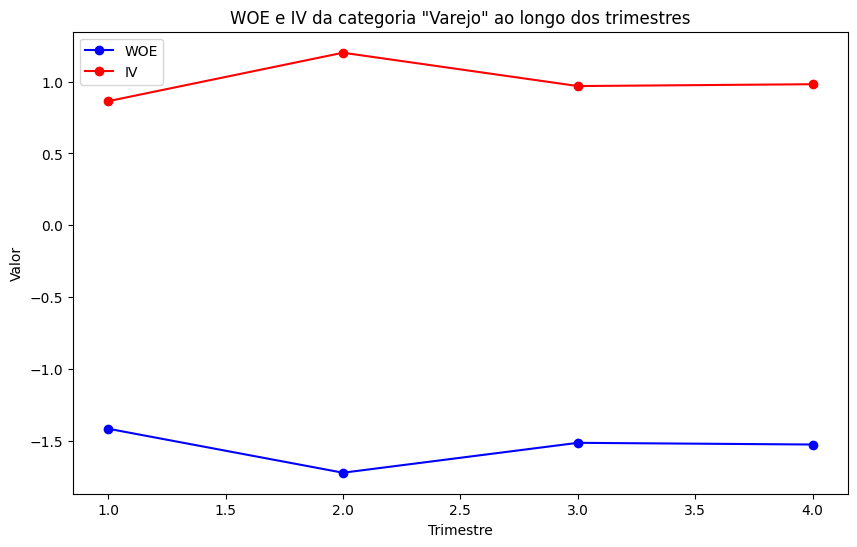

In [57]:
# Função para calcular o WOE e o IV
def calculate_woe_iv(df, feature, target):
    freq_table = pd.crosstab(df[feature], df[target])
    freq_table['event_rate'] = freq_table[1] / freq_table.sum(axis=1)
    freq_table['non_event_rate'] = freq_table[0] / freq_table.sum(axis=1)
    freq_table['woe'] = np.log(freq_table['event_rate'] / freq_table['non_event_rate'])
    freq_table['iv'] = (freq_table['event_rate'] - freq_table['non_event_rate']) * freq_table['woe']
    return freq_table['woe'], freq_table['iv']

# Definir a variável de destino
target_variable = 'flag_credito'

# Criar dicionários para armazenar WOE e IV
woe_results = {}
iv_results = {}

# Calcular WOE e IV para cada categoria
for category in df['categoria'].unique():
    woe, iv = calculate_woe_iv(df[df['categoria'] == category], 'Trimestre', target_variable)
    woe_results[category] = woe
    iv_results[category] = iv

# Plotar gráficos de WOE e IV para cada categoria
for category, woe in woe_results.items():
    plt.figure(figsize=(10, 6))
    plt.plot(woe.index, woe.values, marker='o', linestyle='-', color='b', label='WOE')
    plt.plot(iv_results[category].index, iv_results[category].values, marker='o', linestyle='-', color='r', label='IV')
    plt.xlabel('Trimestre')
    plt.ylabel('Valor')
    plt.title(f'WOE e IV da categoria "{category}" ao longo dos trimestres')
    plt.legend()
    plt.show()

## Conclua

- Quais categorias parece ter maior proporção de notas com retornos maiores que zero?
- Essas diferenças são estáveis no tempo?

Dicas:<br>
- Considere que a quantidade de notas vem aumentando
- Considere que há períodos bem atípicos no histórico
- Considere que a partir de janeiro de 2020 o público é mais parecido com o público atual (2022), seja por pandemia, seja por crescimento do público, e considere os dados dessa data em diante na sua conclusão.

> * <span style="font-family: Serif; color: green;"> As Categoria "Restaurantes" e "Construção" possuem um WOE acima de zero e estáveis no tempo, indicando uma proporção positiva de notas com retornos acima de zero e o seu IV começa abaixo de 0 terminando acima de 0 no eixo y, sugerindo que a discriminação dessa categoria melhora com o tempo. A categoria  </span>